# Video Classification with a CNN-RNN Architecture

## Dependencies

In [1]:
!pip install kagglehub imutils --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [718]:
import os

from imutils import paths

import imageio
import cv2
from IPython.display import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import top_k_categorical_accuracy

import kagglehub

## Data Loading

Get Tensorflow Docs

In [3]:
!pip install -q git+https://github.com/tensorflow/docs


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Acquire subsampled version of the original UCF101 dataset

In [4]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

Download latest version of the ucf101-action-recognition dataset

In [5]:
# path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

# print("Path to dataset files:", path)
# train_df = pd.read_csv(path+"/train.csv")
# train_df
# train_df["label"].unique()

Load the train and test datasets

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
129,v_PlayingCello_g09_c06.avi,PlayingCello
262,v_Punch_g11_c05.avi,Punch
47,v_CricketShot_g14_c06.avi,CricketShot
89,v_CricketShot_g21_c04.avi,CricketShot
299,v_Punch_g17_c01.avi,Punch
208,v_PlayingCello_g21_c04.avi,PlayingCello
452,v_ShavingBeard_g22_c03.avi,ShavingBeard
454,v_ShavingBeard_g22_c05.avi,ShavingBeard
44,v_CricketShot_g14_c03.avi,CricketShot
170,v_PlayingCello_g16_c01.avi,PlayingCello


## Hyperparameters

In [514]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100 # TODO: Use 100 for final training

MAX_SEQ_LENGTH = 20 # TODO: Check the distribution of the sequence lengths
NUM_FEATURES = 2048

## Data Preprocessing

#### Video preprocessing

 Function to resize the video frames to a square shape without distorting their content

In [8]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]  # Get the height (y) and width (x) of the image
    min_dim = min(y, x)       # Find the smallest dimension (either height or width)
    start_x = (x // 2) - (min_dim // 2)  # Calculate the horizontal starting point for the crop
    start_y = (y // 2) - (min_dim // 2)  # Calculate the vertical starting point for the crop
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]  # Return the cropped square

Crop,resize, and reorder color channels

In [9]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame) # Crop center square
            frame = cv2.resize(frame, resize) # Resize the image (In this case to 224x224)
            frame = frame[:, :, [2, 1, 0]] # Reorder the color channels from OpenCV BGR to RGB
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

### Feature Extraction

Using a pre-trained network to extract meaningful features from the extracted frames, the InceptionV3 model pretrained on ImageNet-1k dataset

In [10]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [11]:
feature_extractor = build_feature_extractor()

Encode the class labels as integers using the Keras StringLookup layer

In [158]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)

class_vocab = label_processor.get_vocabulary()

print(f"Vocabulary: {class_vocab}")

Vocabulary: ['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Extract frame_features, frame_masks and labels

In [13]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,),dtype="bool")
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [14]:
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [57]:
total_samples, frame_count, num_of_features = train_data[0].shape

print(f"""Frame features in train set: {train_data[0].shape} 
    → {total_samples} samples
    → {frame_count} frames per video
    → {num_of_features} features per frame
""")

total_samples, mask_count = train_data[1].shape
print(f"""Frame masks in train set: {train_data[1].shape} 
    → {total_samples} samples
    → {mask_count} masks per video
""")

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Frame features in train set: (594, 20, 2048) 
    → 594 samples
    → 20 frames per video
    → 2048 features per frame

Frame masks in train set: (594, 20) 
    → 594 samples
    → 20 masks per video

Frame features in test set: (224, 20, 2048)
Frame masks in test set: (224, 20)


## Sequence model architecture

Recurrent Neural Network architecture with GRU (Gated Recurrent Unit) layers

In [396]:
def get_rnn_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    # x = keras.layers.Dense(8, activation="relu")(x) # TODO: Experiment with the dense layers
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="adam",
        metrics=["accuracy"]
    )
    
    return rnn_model

## Model Training

Utility to run the experiment

In [523]:
def train_and_evaluate_model(weights_file_path=None, seq_model=None):
    checkpoint = ModelCheckpoint(
        weights_file_path,
        monitor="val_loss",
        mode="min",  # Save the model when the loss decreases (when model improves)
        save_weights_only=True,
        save_best_only=True,
        verbose=1,
    )

    # TODO: Return this
    early_stopping = EarlyStopping(
        monitor="val_loss", 
        patience=5, 
        restore_best_weights=True, 
        verbose=1
    )
    
    # Train the model
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )
    
    # Load the best weights after training
    seq_model.load_weights(weights_file_path)

    # Evaluate the model on a test sample
    print("\nEvaluating the model...")
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return seq_model, history

Run the experiment

In [524]:
weights_file_path = "models/ckpt.rnn_model.weights.h5"
rnn_seq_model = get_rnn_sequence_model()

sequence_model, history = train_and_evaluate_model(weights_file_path, rnn_seq_model)

Epoch 1/100
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1784 - loss: 1.6394
Epoch 1: val_loss improved from inf to 1.81233, saving model to models/ckpt.rnn_model.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2077 - loss: 1.6107 - val_accuracy: 0.3128 - val_loss: 1.8123
Epoch 2/100
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6206 - loss: 1.3236
Epoch 2: val_loss did not improve from 1.81233
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6376 - loss: 1.3014 - val_accuracy: 0.0782 - val_loss: 2.0921
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7898 - loss: 0.9919
Epoch 3: val_loss did not improve from 1.81233
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7916 - loss: 0.9868 - val_accuracy: 0.0000e+00 - val_loss: 2.4517
Epoch 4/100
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8594 - loss: 0.6674
Epoch 4: val_loss did not improve from 1.81233
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8580 - loss:

Visualise the training and validation loss and accuracy

In [780]:
def visualize_training_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

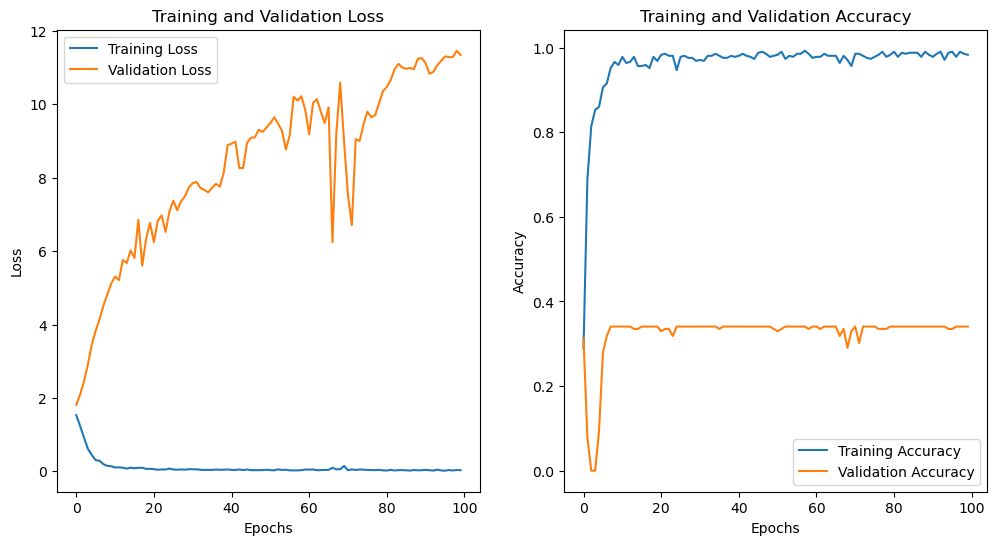

In [781]:
visualize_training_metrics(history)

## Model Evaluation

Preprocess the data for batch testing

In [754]:
def prepare_all_test_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # Initialize placeholders for all frames and masks for the entire dataset
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Process each video
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
            temp_frame_mask[i, :length] = 1

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [762]:
# Compare with this:

# def prepare_all_videos(df, root_dir):
#     num_samples = len(df)
#     video_paths = df["video_name"].values.tolist()
#     labels = df["tag"].values
#     labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

#     # `frame_masks` and `frame_features` are what we will feed to our sequence model.
#     # `frame_masks` will contain a bunch of booleans denoting if a timestep is
#     # masked with padding or not.
#     frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
#     frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

#     # For each video.
#     for idx, path in enumerate(video_paths):
#         # Gather all its frames and add a batch dimension.
#         frames = load_video(os.path.join(root_dir, path))
#         frames = frames[None, ...]

#         # Initialize placeholders to store the masks and features of the current video.
#         temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,),dtype="bool")
#         temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

#         # Extract features from the frames of the current video.
#         for i, batch in enumerate(frames):
#             video_length = batch.shape[0]
#             length = min(MAX_SEQ_LENGTH, video_length)
#             for j in range(length):
#                 temp_frame_features[i, j, :] = feature_extractor.predict(
#                     batch[None, j, :], verbose=0,
#                 )
#             temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

#         frame_features[idx,] = temp_frame_features.squeeze()
#         frame_masks[idx,] = temp_frame_mask.squeeze()

#     return (frame_features, frame_masks), labels

In [756]:
test_data, test_labels = prepare_all_test_videos(test_df, "test")

In [765]:
test_features, test_masks = test_data

Evaluate on the entire dataset

In [ ]:
loss, accuracy = sequence_model.evaluate([test_features, test_masks], test_labels, batch_size=32)

print(f"Test Loss: {loss :.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3863 - loss: 1.4579 
Test Loss: 1.5205
Test Accuracy: 47.77%


## Model testing

#### Evaluation with single sample

Function to prepare the test video

In [767]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ),dtype="bool" )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, frames_batch in enumerate(frames):
        video_length = frames_batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(frames_batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

Make predictions on a single video

In [768]:
def sequence_prediction(seq_model, frames, true_label):
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = seq_model.predict([frame_features, frame_mask])[0]
        
    print("\nTop-5 actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    # Get the top-1 predicted label (highest probability)
    predicted_index = np.argmax(probabilities)
    predicted_label = class_vocab[predicted_index]

    # Convert true_label to index to align with predicted index format
    true_label_index = class_vocab.index(true_label)

    # Prepare y_true and y_pred as binary arrays (1 for correct label, 0 for others)
    y_true = np.zeros(len(class_vocab))
    y_pred = np.zeros(len(class_vocab))
    y_true[true_label_index] = 1
    y_pred[predicted_index] = 1
 
    return y_true, y_pred, predicted_label

Display predicted image as GIF

In [769]:
def display_as_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")

Choosing a random video to use for prediction

Test video path: v_PlayingCello_g03_c04.avi
Label: PlayingCello

Test video frames shape:
  - 189 frames
  - 224 pixels (height) x 224 pixels (width)
  - 3 color channels



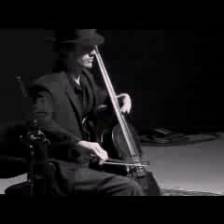

In [770]:
random_index = np.random.randint(len(test_df))

# Get the test video path
test_video = test_df["video_name"].values[random_index]

# Get the true label of the test video
true_label_index = test_labels.tolist()[random_index][0]
true_label = class_vocab[true_label_index]

test_video_frames = load_video(os.path.join("test", test_video))

print(f"Test video path: {test_video}")
print(f"Label: {true_label}")

print(f"""
Test video frames shape:
  - {test_video_frames.shape[0]} frames
  - {test_video_frames.shape[1]} pixels (height) x {test_video_frames.shape[2]} pixels (width)
  - {test_video_frames.shape[3]} color channels
""")

display_as_gif(test_video_frames[:MAX_SEQ_LENGTH])

Run the prediction on the test video

In [771]:
y_true, y_pred, predicted_label = sequence_prediction(sequence_model, test_video_frames, true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Top-5 actions:
  ShavingBeard: 27.39%
  Punch: 24.59%
  CricketShot: 22.26%
  PlayingCello: 13.55%
  TennisSwing: 12.20%


In [772]:
print(f"\nTrue label: {true_label}")
print(f"Predicted label: {predicted_label}")

print(f"y_true: {y_true}")
print(f"y_pred: {y_pred}")


True label: PlayingCello
Predicted label: ShavingBeard
y_true: [0. 1. 0. 0. 0.]
y_pred: [0. 0. 0. 1. 0.]


Evaluation Metrics

In [773]:
def display_evaluation_metrics(y_true, y_pred, predictions=None, target_classes=None):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Top-1 Accuracy: {accuracy * 100:.2f}%")

    # Calculate Top-k accuracy
    if predictions is not None:
        k = 2
        top_k_acc = top_k_accuracy_score(y_true, predictions, k=k)
        print(f"Top-{k} Accuracy: {top_k_acc * 100:.2f}%")
        
        # TODO: Compare these
        # Using TensorFlow's top_k_categorical_accuracy
        # top_k_acc = top_k_categorical_accuracy(y_true, predictions, k=2).numpy().mean()

    report = classification_report(y_true, y_pred, target_names=target_classes, zero_division=0)
    print("Classification Report:\n", report)

In [774]:
display_evaluation_metrics(y_true, y_pred)

Top-1 Accuracy: 60.00%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5



#### Evaluation on the entire test set

In [775]:
predictions = sequence_model.predict([test_features, test_masks], batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [776]:
display_evaluation_metrics(test_labels, predicted_classes, predictions, class_vocab)

Top-1 Accuracy: 47.77%
Top-2 Accuracy: 65.62%
Classification Report:
               precision    recall  f1-score   support

 CricketShot       0.33      0.02      0.04        49
PlayingCello       1.00      0.68      0.81        44
       Punch       0.75      0.92      0.83        39
ShavingBeard       0.28      0.93      0.43        43
 TennisSwing       0.00      0.00      0.00        49

    accuracy                           0.48       224
   macro avg       0.47      0.51      0.42       224
weighted avg       0.45      0.48      0.39       224



In [777]:
def display_confusion_matrix(y_true, y_pred, target_classes, show_plot=False):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    if show_plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=target_classes, yticklabels=target_classes)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
    else:
        print(conf_matrix)

In [778]:
true_labels = np.array(test_labels).flatten()
display_confusion_matrix(true_labels, predicted_classes, class_vocab, show_plot=False)

[[ 1  0  0 48  0]
 [ 2 30  8  4  0]
 [ 0  0 36  3  0]
 [ 0  0  3 40  0]
 [ 0  0  1 48  0]]
